In [1]:
import pandas as pd
import re
import os
import time
import gc
from tqdm import tqdm

In [2]:
#parsing log files
data_arr = []
errors_file = 'errors123.txt'
with open('../input/web-server-access-logs/access.log') as log:
    for line in log.readlines():
        match = re.match(r'^(?P<client>\S+) \S+ (?P<userid>\S+) \[(?P<datetime>[^\]]+)\] "(?P<method>[A-Z]+) (?P<request>[^ "]+)? HTTP/[0-9.]+" (?P<status>[0-9]{3}) (?P<size>[0-9]+|-) "(?P<referrer>[^"]*)" "(?P<useragent>[^"]*)', line)
        if match:
            data_arr.append([match.group(1), match.group(3), match.group(4), match.group(5), match.group(6), match.group(7), match.group(8), match.group(9)])
        else:
            with open(errors_file, 'at') as errfile:
                print((line), file=errfile)
df = pd.DataFrame(data_arr, columns=['ip_address', 'datetime', 'request_type', 'request', 'status', 'size', 'referer', 'user_agent'])

In [ ]:
#formatting for datetime
df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%b/%Y:%H:%M:%S %z')
df['status'] = df['status'].astype('int16')
df['size'] = df['size'].astype('int32')

In [3]:
df

,ip_address,datetime,request_type,request,status,size,referer,user_agent
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET,/image/60844/productModel/200x200,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET,/image/61474/productModel/200x200,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET,/image/14925/productModel/100x100,200,1696,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
...,...,...,...,...,...,...,...,...
10364860,188.229.21.56,2019-01-26 20:29:13+03:30,GET,/content/view/shoppingRules,302,0,https://www.zanbil.ir/m/product/32106/62372/%D...,Mozilla/5.0 (Linux; Android 7.0; SM-N920C Buil...
10364861,5.127.220.71,2019-01-26 20:29:13+03:30,GET,/apple-touch-icon-120x120.png,404,32420,-,MobileSafari/604.1 CFNetwork/976 Darwin/18.2.0
10364862,5.213.7.50,2019-01-26 20:29:13+03:30,GET,/m/product/18962/%D8%BA%D8%B0%D8%A7-%D8%B3%D8%...,200,20959,https://www.google.com/,Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 like...
10364863,109.125.169.52,2019-01-26 20:29:13+03:30,GET,/image/%7B%7BbasketItem.id%7D%7D?type=productM...,200,5,https://www.zanbil.ir/,Mozilla/5.0 (Windows NT 6.1; rv:64.0) Gecko/20...


In [4]:
#keeping count of user agents
df['GoogleBot'] = df['user_agent'].apply(lambda x: 1 if str(x).find("Googlebot")>=0 else 0)
df['BingBot'] = df['user_agent'].apply(lambda x: 1 if str(x).find("bingbot")>=0 else 0)

In [5]:
df=df.sort_values(by=['datetime'])

In [6]:
from pathlib import Path
import plotly.graph_objs as go

In [7]:
bdf = df['datetime'][df['BingBot']==1]
bdf = bdf.apply(lambda x: x.split(':')[0])
bdf_final = pd.DataFrame(
    {'datetime': list(bdf.value_counts(sort=False).index),
     'frequency': bdf.value_counts(sort=False).values
    })

In [8]:
Gdf = df['datetime'][df['GoogleBot']==1]
Gdf = Gdf.apply(lambda x: x.split(':')[0])
Gdf_final = pd.DataFrame(
    {'datetime': list(Gdf.value_counts(sort=False).index),
     'frequency': Gdf.value_counts(sort=False).values
    })

In [9]:
from sklearn import preprocessing
bdf_f=preprocessing.normalize([list(bdf_final['frequency'])])
bdf_final["frequency"]=bdf_f[0]
Gdf_f=preprocessing.normalize([list(Gdf_final['frequency'])])
Gdf_final["frequency"]=Gdf_f[0]

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = bdf_final['datetime'], y = bdf_final['frequency'], name = 'Bingbot frequency'+'        ', line = dict(color = 'firebrick', width = 2)))
fig.add_trace(go.Scatter(x = Gdf_final['datetime'], y = Gdf_final['frequency'], name = 'Googlebot frequency'+'        ', line = dict(color = 'royalblue', width = 2)))
fig.update_layout(font_family = 'Times New Roman, monospace, 100', font_color = 'black', plot_bgcolor = '#dbfdff', xaxis_title = 'Time', title = "Time(in Hrs) VS Frequency" )
fig.show()

In [11]:
# run this from a normal command line
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 20.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [12]:
import spacy
from spacy.tokens import Doc
nlp = spacy.load("en_core_web_md")

In [13]:
#tokenizing
%time df['tokenized'] = df['request'][:103648].apply(nlp)

CPU times: user 12min 6s, sys: 2.17 s, total: 12min 8s
Wall time: 12min 8s


In [14]:

df['sent_vectors'] = df['tokenized'][:103648].apply(lambda x: x.vector)


In [15]:
vectors = df['sent_vectors'][:103648].apply(pd.Series).to_numpy()

In [16]:
vectors.shape

(103648, 300)

In [18]:
import numpy as np
with open('vector.npy', 'wb') as f:
    np.save(f, vectors)

In [20]:
from sklearn.cluster import KMeans
k = 18
kmeans = KMeans(k)
kmeans.fit(vectors)
kmeans.predict(vectors)

array([2, 0, 0, ..., 0, 0, 0], dtype=int32)

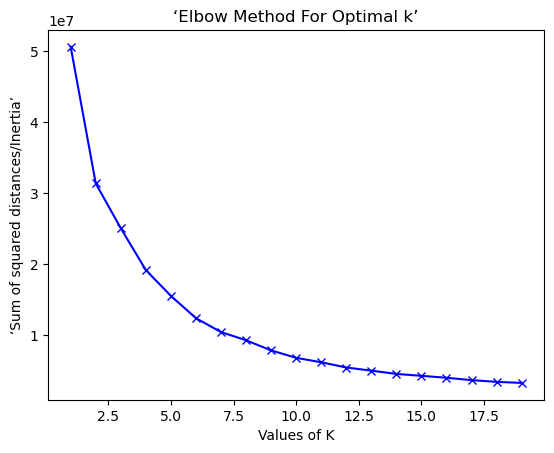

In [25]:
#elbow method
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Sum_of_squared_distances = []
K = range(1,20)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(vectors)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('‘Sum of squared distances/Inertia’') 
plt.title('‘Elbow Method For Optimal k’')
plt.show()

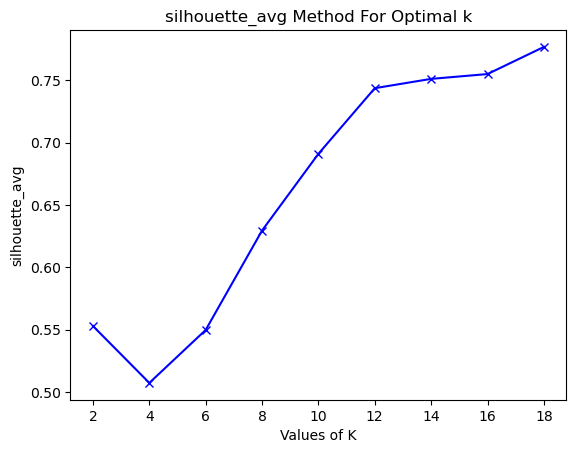

In [29]:
#silhoutte method
silhouette_avg = []
K = range(2,20,2)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(vectors)
    cluster_labels = kmeans.labels_
#     print(cluster_labels)
    silhouette_avg.append(silhouette_score(vectors, cluster_labels))
plt.plot(K,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('silhouette_avg') 
plt.title('silhouette_avg Method For Optimal k')
plt.show()